In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.autograd import Variable
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from livelossplot import PlotLosses

Using TensorFlow backend.


In [2]:
base_string = "()()" + (32 - 4) * " "

def shuffle_string(s):
    indices = np.arange(len(s), dtype='uint8')
    np.random.shuffle(indices)
    return "".join(base_string[i] for i in indices)

def is_correct(seq):
    open_brackets = 0
    val = {"(": 1, " ": 0, ")": -1}
    for c in seq:
        open_brackets += val[c]
        if open_brackets < 0:
            return False
    return open_brackets == 0

char2id = {" ": 0, "(": 1, ")": 2}

def generate_pairs(size):
    X = np.zeros((size, 3, len(base_string)), dtype='float32')
    Y = np.zeros((size), dtype='int64')
    for i in range(size):
        s = shuffle_string(base_string)
        Y[i] = int(is_correct(s))
        for j, c in enumerate(s):
            X[i, char2id[c], j] = 1.
    return X, Y

def generate_train_test_pairs(size):
    X, Y = generate_pairs(size)
    return train_test_split(X, Y, test_size=0.25, random_state=42)

In [3]:
x = shuffle_string(base_string)
print(x, "- correct" if is_correct(x) else "- incorrect")

     (        )         ( )      - correct


In [4]:
X_train, X_test, Y_train, Y_test = generate_train_test_pairs(1000)

trainloader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)),
                         batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)),
                         batch_size=32, shuffle=False)

In [5]:
class Recurrent(nn.Module):
    def __init__(self, rnn_size):
        super(Recurrent, self).__init__()
        self.lstm = nn.GRU(input_size=3, hidden_size=rnn_size)
        self.fc = nn.Linear(rnn_size, 2)

    def forward(self, x):
        x = x.permute(2, 0, 1)
        output, _ = self.lstm(x)
        last_output = output[-1, :, :]
        res = self.fc(last_output)
        return res

In [6]:
net = Recurrent(8)
criterion = nn.modules.CrossEntropyLoss(size_average=False)
optimizer = optim.Adam(net.parameters(), lr=0.003)

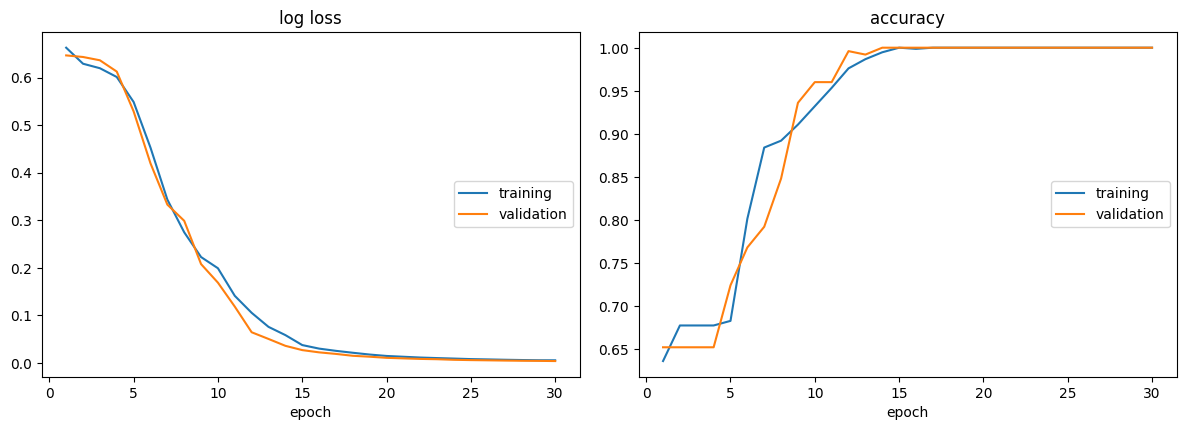

In [7]:
liveloss = PlotLosses()

for epoch in range(30):

    epoch_loss = 0.0
    epoch_correct = 0
    epoch_loss_val = 0.0
    epoch_correct_val = 0

    net.train()
    for inputs, labels in trainloader:
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.data[0]
        epoch_correct += (outputs.max(1)[1] == labels).sum().data[0]

    avg_loss = epoch_loss / len(trainloader.dataset)
    avg_accuracy = epoch_correct / len(trainloader.dataset)

    net.eval()
    for inputs, labels in testloader:
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        epoch_loss_val += loss.data[0]
        epoch_correct_val += (outputs.max(1)[1] == labels).sum().data[0]

    avg_loss_val = epoch_loss_val / len(testloader.dataset)
    avg_accuracy_val = epoch_correct_val / len(testloader.dataset)

    liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val,
        'accuracy': avg_accuracy,
        'val_accuracy': avg_accuracy_val
    })
    liveloss.draw()